# Project: GNN vs. CNN for Domination Number Prediction

### The Challenge: Predicting an NP-Hard Graph Property

The **domination number** of a graph is the size of the smallest "dominating set" of vertices, where every vertex in the graph is either in the set or adjacent to a vertex in the set. Finding this number is a classic NP-hard problem, meaning that for large graphs, exact computation becomes incredibly slow and eventually impossible.

This notebook explores using machine learning as a powerful alternative to find a fast and accurate approximation of the domination number.

### The Contenders: Two Competing Architectures

We will build, train, and compare two fundamentally different neural network architectures for this task:

1.  **Convolutional Neural Network (CNN):** This model treats the graph as an image. We convert the graph's adjacency matrix into a 2D pixel representation and apply a standard CNN, similar to those used in image recognition.
    *   **Limitation:** This approach forces the graph into a fixed-size grid (64x64 in our case) and may lose some of the rich, native structural information.

2.  **Graph Neural Network (GNN):** This model is designed specifically to work with graph data. It operates directly on the graph's nodes and edges, learning by passing messages between neighbors.
    *   **Advantage:** This architecture inherently understands and utilizes the graph's topology, making it a more natural fit for graph-based problems.

### The Goal

The primary goal of this project is to conduct a head-to-head comparison to answer the question: **Which architecture is better suited for predicting a graph's domination number?** We will evaluate them based on:

*   **Accuracy:** How close are the predictions to the true values?
*   **Speed:** How quickly can each model make a prediction compared to an exact solver?
*   **Scalability:** How does the performance of each model change as the graphs get larger?

Objective: Direct Comparison of GNN vs. CNN
The goal is not to repeat earlier analyses involving GraphCalc. Instead, the focus is a direct comparison between the GNN and CNN models.

What This Involves
Data: Both models will be trained on the same set of graphs to ensure a fair comparison.

Evaluation: Performance on the test set (R², MAE), runtime, and behavior as graph size increases will be compared side by side using unified plots and tables.

GraphCalc Role: GraphCalc is no longer a competitor—it serves only as a tool to generate ground-truth domination numbers.

Final Comparison Outputs
Accuracy Plot: A single plot with three lines — "True Values", "GNN Predictions", "CNN Predictions".

Runtime Plot: A single plot with two lines — "GNN Runtime", "CNN Runtime".

In [1]:
# --- IMPORTS FOR GNN vs. CNN COMPARISON ---

# Core Data Science & Visualization Libraries (Common to Both)
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import graphcalc as gc
from scipy import stats

# --- GNN Specific Imports (PyTorch & PyTorch Geometric) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
# Importing the specific GNN layers we found to be most successful
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, BatchNorm


# --- CNN Specific Imports (TensorFlow & Keras & PIL) ---
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Input, Model
from PIL import Image

print("All necessary libraries for GNN and CNN comparison have been imported.")

All necessary libraries for GNN and CNN comparison have been imported.


In [2]:
# --- Graph Helper Functions ---
# These functions are general utilities for working with NetworkX graphs
# and are independent of the model type (GNN or CNN).

def neighborhood(G, v):
    """Returns the set of neighbors of a node."""
    return list(nx.neighbors(G, v))

def set_neighborhood(G, nodes):
    """Returns the union of neighborhoods for a set of nodes."""
    N = set()
    for n in nodes:
        N |= set(neighborhood(G, n))
    return list(N)

def closed_neighborhood(G, v):
    """Returns the union of the neighborhood of a node and the node itself."""
    return list(set(neighborhood(G, v)).union([v]))


In [3]:
# --- Data Generation for Both Models ---

# This function is required by the CNN to convert graph structures into images.
# The GNN does not use this.
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / np.max(combined_matrix) * 255).astype(np.uint8) if np.max(combined_matrix) > 0 else np.zeros_like(combined_matrix, dtype=np.uint8)

    return Image.fromarray(combined_image, 'L')


# This function calculates the ground truth domination number.
def domination_number(G):
    return gc.domination_number(G)


# This function generates the dataset for both the GNN and CNN from the same source graphs.
def generate_combined_dataset(num_graphs, max_nodes):
    """
    Generates a dataset of random graphs and prepares the data formats
    required for both the GNN and the CNN models.
    """
    print(f"Generating a shared dataset of {num_graphs} graphs...")
    
    # Lists to hold the data for each model type
    gnn_data_list = []
    cnn_image_list = []
    cnn_label_list = []

    for _ in range(num_graphs):
        # Create the same base graph for both models
        num_nodes = random.randint(5, max_nodes)
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        if G.number_of_edges() == 0: continue

        # Calculate the label once
        dom_num = domination_number(G)

        # 1. Prepare data for the GNN
        gnn_data = from_networkx(G)
        gnn_data.x = torch.tensor([d for _, d in G.degree()], dtype=torch.float).view(-1, 1)
        gnn_data.y = torch.tensor([dom_num], dtype=torch.float)
        gnn_data_list.append(gnn_data)

        # 2. Prepare data for the CNN
        image = convert_to_heatmap_image(G, target_size=64)
        cnn_image_list.append(np.array(image))
        cnn_label_list.append(dom_num)
        
    print("Dataset generation complete.")
    return gnn_data_list, cnn_image_list, cnn_label_list


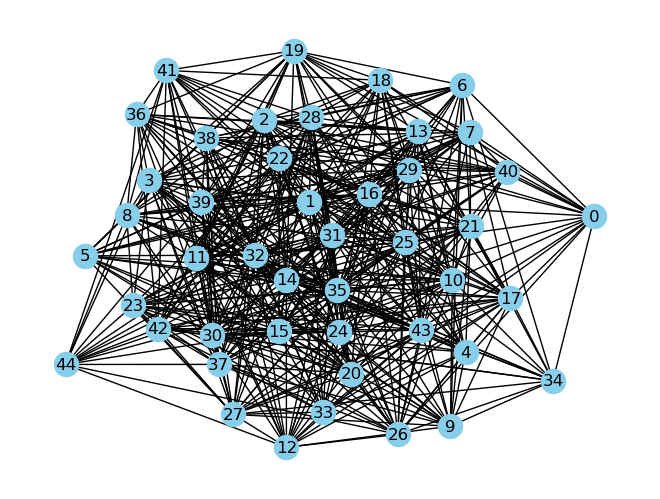

In [4]:
# --- Visual Test with a Single Graph ---
# This cell is for a quick visual inspection of a sample random graph.
# It is independent of the model type.

G_sample = nx.gnp_random_graph(45, 0.5)
nx.draw(G_sample, with_labels=True, node_color='skyblue')
plt.show()

Visualizing the graph's representation as a heatmap image for the CNN...


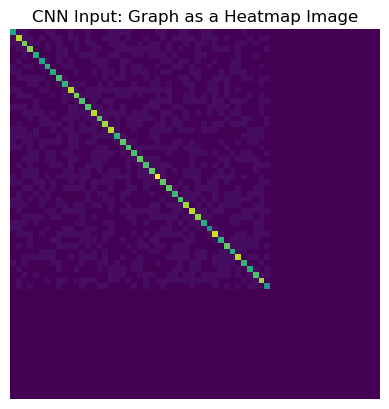

In [5]:
# --- Visualizing the CNN's Input Format ---
# The GNN works directly with the graph structure.
# In contrast, the CNN sees the graph as a 2D image. This cell shows what that image looks like.
# We can use the sample graph we created in the previous cell.

print("Visualizing the graph's representation as a heatmap image for the CNN...")

# Ensure the sample graph exists from the previous cell, otherwise create it.
if 'G_sample' not in locals():
    G_sample = nx.gnp_random_graph(45, 0.5)

image = convert_to_heatmap_image(G_sample)
plt.imshow(image, cmap='viridis')
plt.title("CNN Input: Graph as a Heatmap Image")
plt.axis('off')
plt.show()

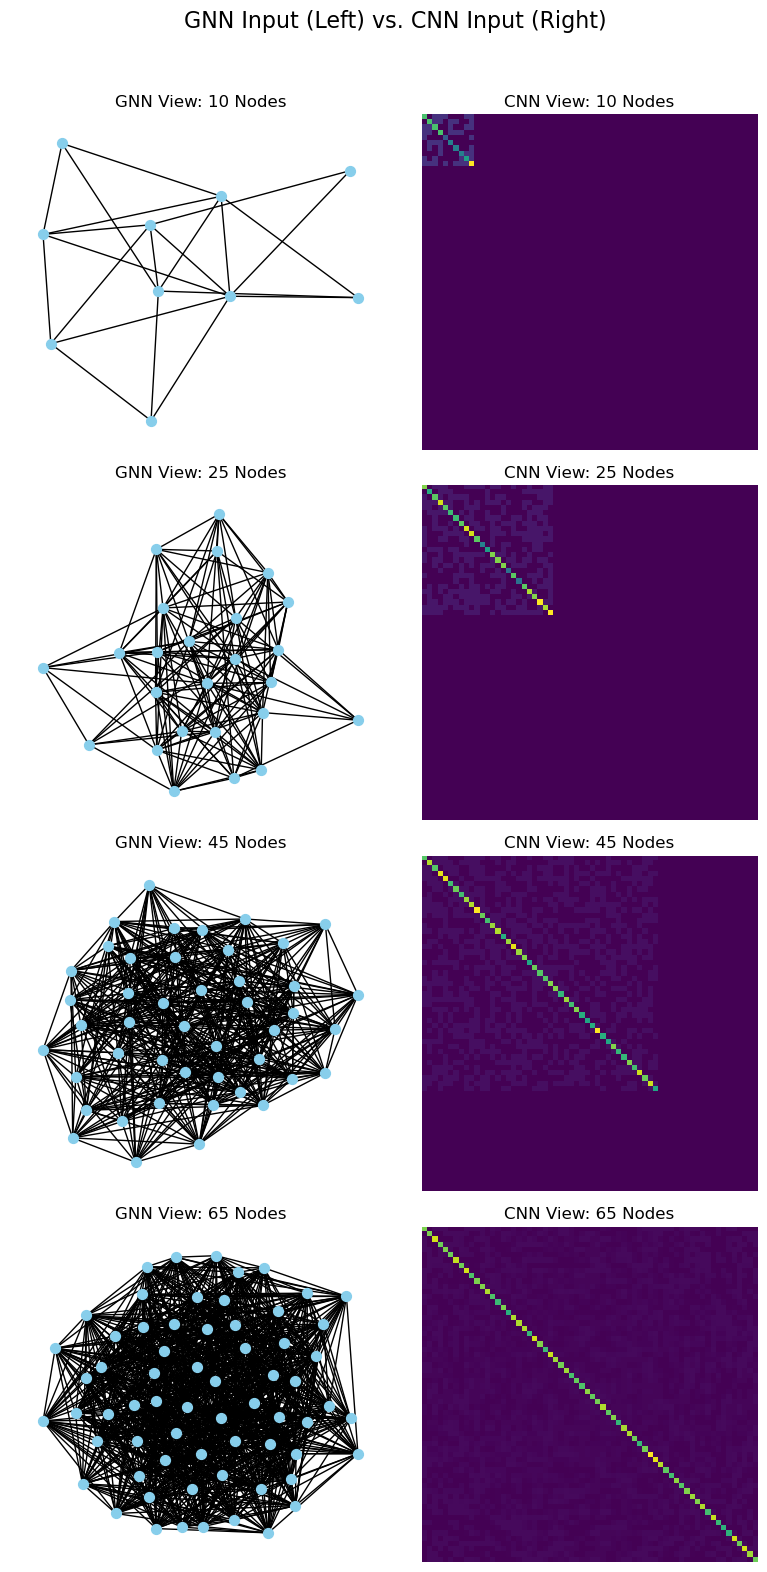

In [6]:
# --- Visualizing Different Graph Sizes and Their Representations ---
#
# This cell shows how graphs of different sizes are represented for each model.
# On the left, we see the raw graph structure that the GNN uses.
# On the right, we see the corresponding 2D heatmap image that the CNN uses.
#

graph_samples = [
    nx.gnp_random_graph(10, 0.5, seed=42),
    nx.gnp_random_graph(25, 0.5, seed=42),
    nx.gnp_random_graph(45, 0.5, seed=42),
    nx.gnp_random_graph(65, 0.5, seed=42)
]

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(8, 16))
fig.suptitle('GNN Input (Left) vs. CNN Input (Right)', fontsize=16)

for i, G in enumerate(graph_samples):
    # --- Left Column: GNN's View (The Actual Graph) ---
    ax_gnn = axs[i, 0]
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, ax=ax_gnn, node_color='skyblue', node_size=50)
    ax_gnn.set_title(f"GNN View: {G.number_of_nodes()} Nodes")
    ax_gnn.axis('off')

    # --- Right Column: CNN's View (The Heatmap Image) ---
    ax_cnn = axs[i, 1]
    image = convert_to_heatmap_image(G)
    ax_cnn.imshow(image, cmap='viridis')
    ax_cnn.set_title(f"CNN View: {G.number_of_nodes()} Nodes")
    ax_cnn.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
# --- Generate and Split the Combined Dataset ---
#
# In this step, we will:
# 1. Call our `generate_combined_dataset` function to create the raw data for both models.
# 2. Split this data into training and testing sets for both the GNN and the CNN.
#
# It is crucial to use the same `random_state` for both splits to ensure that
# the i-th graph in the GNN's test set corresponds to the i-th graph in the CNN's test set.
#

# Dataset parameters
NUM_GRAPHS = 2_000
MAX_NODES = 64
TARGET_SIZE = 64 # For CNN image dimensions

# 1. Generate the raw, combined data
gnn_data_list, cnn_image_list, cnn_label_list = generate_combined_dataset(NUM_GRAPHS, MAX_NODES)


# 2. Split the data for the GNN model
gnn_train_data, gnn_test_data = train_test_split(
    gnn_data_list,
    test_size=0.2,
    random_state=42
)

# 3. Format and split the data for the CNN model
# First, convert lists to NumPy arrays
cnn_X = np.array(cnn_image_list).reshape(-1, TARGET_SIZE, TARGET_SIZE, 1)
cnn_y = np.array(cnn_label_list)

# Then, split using the same random_state
cnn_X_train, cnn_X_test, cnn_y_train, cnn_y_test = train_test_split(
    cnn_X,
    cnn_y,
    test_size=0.2,
    random_state=42
)


# 4. Print a summary of the created datasets
print("\n--- Dataset Splitting Complete ---")
print(f"Total graphs generated: {len(gnn_data_list)}")
print("-" * 35)
print("GNN Data:")
print(f"  - Training set size: {len(gnn_train_data)}")
print(f"  - Test set size:     {len(gnn_test_data)}")
print("\nCNN Data:")
print(f"  - X_train shape: {cnn_X_train.shape}")
print(f"  - y_train shape: {cnn_y_train.shape}")
print(f"  - X_test shape:  {cnn_X_test.shape}")
print(f"  - y_test shape:  {cnn_y_test.shape}")

# Verify that the test set labels are the same (optional but good practice)
assert np.allclose(cnn_y_test, [d.y.item() for d in gnn_test_data]), "Test set labels do not match!"
print("\nVerification successful: Test set labels for GNN and CNN match.")


Generating a shared dataset of 2000 graphs...
Dataset generation complete.

--- Dataset Splitting Complete ---
Total graphs generated: 1979
-----------------------------------
GNN Data:
  - Training set size: 1583
  - Test set size:     396

CNN Data:
  - X_train shape: (1583, 64, 64, 1)
  - y_train shape: (1583,)
  - X_test shape:  (396, 64, 64, 1)
  - y_test shape:  (396,)

Verification successful: Test set labels for GNN and CNN match.


In [9]:
# --- Model Definitions for GNN and CNN ---

# 1. GNN Model Definition (Our best-performing GIN architecture)
class GINRegressor(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=128, out_channels=1):
        super(GINRegressor, self).__init__()
        
        # GIN layer 1 with BatchNorm
        mlp1 = nn.Sequential(nn.Linear(in_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(mlp1, train_eps=True)
        self.bn1 = BatchNorm(hidden_channels)

        # GIN layer 2 with BatchNorm
        mlp2 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(mlp2, train_eps=True)
        self.bn2 = BatchNorm(hidden_channels)
        
        # GIN layer 3 with BatchNorm
        mlp3 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(mlp3, train_eps=True)
        self.bn3 = BatchNorm(hidden_channels)

        # Final MLP head
        self.mlp_head = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()

        x = self.conv3(x, edge_index)
        x = self.bn3(x).relu()
        
        mean_pool = global_mean_pool(x, batch)
        add_pool = global_add_pool(x, batch)
        x_pooled = torch.cat([mean_pool, add_pool], dim=1)
        
        out = self.mlp_head(x_pooled)
        return out.relu()


# 2. CNN Model Definition (CORRECTED to use the Functional API)
def create_cnn_model(input_shape):
    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Chain the layers together, starting from the input
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x) # Output layer for regression
    
    # Create the model by specifying its inputs and outputs
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

print("GNN and CNN model architectures have been defined (CNN corrected).")

GNN and CNN model architectures have been defined (CNN corrected).


In [10]:
# --- 1. Define and Train the GNN Model ---

# First, define the training function for the GNN
def train_gnn_model(model, train_data, epochs=200, lr=0.001, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    
    print("Starting GNN model training...")
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch).view(-1)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
        
        avg_loss = total_loss / len(train_loader.dataset)
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
            
    print("GNN Training finished.")


# Now, create an instance of the GNN model and train it
gnn_model = GINRegressor()
train_gnn_model(gnn_model, gnn_train_data)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting GNN model training...
  Epoch 10/200, Avg Loss: 9.1072, LR: 0.001000
  Epoch 20/200, Avg Loss: 4.4914, LR: 0.001000
  Epoch 30/200, Avg Loss: 4.5417, LR: 0.001000
  Epoch 40/200, Avg Loss: 5.6197, LR: 0.001000
  Epoch 50/200, Avg Loss: 2.7178, LR: 0.000500
  Epoch 60/200, Avg Loss: 2.3129, LR: 0.000500
  Epoch 70/200, Avg Loss: 1.8291, LR: 0.000500
  Epoch 80/200, Avg Loss: 2.3722, LR: 0.000500
  Epoch 90/200, Avg Loss: 1.6398, LR: 0.000500
  Epoch 100/200, Avg Loss: 2.1281, LR: 0.000500
  Epoch 110/200, Avg Loss: 1.7997, LR: 0.000250
  Epoch 120/200, Avg Loss: 2.2348, LR: 0.000250
  Epoch 130/200, Avg Loss: 1.7018, LR: 0.000250
  Epoch 140/200, Avg Loss: 1.7669, LR: 0.000125
  Epoch 150/200, Avg Loss: 1.5893, LR: 0.000125
  Epoch 160/200, Avg Loss: 1.3331, LR: 0.000063
  Epoch 170/200, Avg Loss: 1.1507, LR: 0.000063
  Epoch 180/200, Avg Loss: 1.1780, LR: 0.000063
  Epoch 190/200, Avg Loss: 1.5343, LR: 0.000063
  Epoch 200/200, Avg Loss: 1.4061, LR: 0.000031
GNN Training finis

In [11]:
# --- 2. Define and Train the CNN Model ---

# First, create an instance of the CNN model
cnn_model = create_cnn_model(input_shape=(TARGET_SIZE, TARGET_SIZE, 1))
print("--- CNN Model Summary ---")
cnn_model.summary()

# Now, train the model using the .fit() method
print("\nStarting CNN model training...")
history = cnn_model.fit(
    cnn_X_train, 
    cnn_y_train, 
    epochs=25,          # Increased epochs slightly for better comparison
    validation_split=0.2,
    verbose=1           # Set to 1 to see progress bar
)
print("CNN Training finished.")

--- CNN Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)


Starting CNN model training...
Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 384.9650 - mae: 8.3138 - val_loss: 6.7147 - val_mae: 1.5515
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.3492 - mae: 1.2939 - val_loss: 6.0144 - val_mae: 1.5627
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.8251 - mae: 1.2480 - val_loss: 4.5135 - val_mae: 1.1172
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.1744 - mae: 1.2382 - val_loss: 3.4622 - val_mae: 0.8287
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.5325 - mae: 0.8180 - val_loss: 3.8769 - val_mae: 1.0509
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5686 - mae: 0.8817 - val_loss: 3.7021 - val_mae: 0.9807
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.5380 - mae: 0.7804 - val_loss: 3.2221 - val_mae: 0.8266
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.6792 - mae: 0.7740 - val_loss: 3.5747 - val_mae: 0.9080
Epoch 9/25
40/40 ━━━━━━━━━━━━━

Evaluating GNN model...
Evaluating CNN model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Performance Comparison on Test Set ---
GNN Model:
  - Mean Absolute Error (MAE): 0.4988
  - R-squared (R²):            0.9819

CNN Model:
  - Mean Absolute Error (MAE): 0.6943
  - R-squared (R²):            0.9002


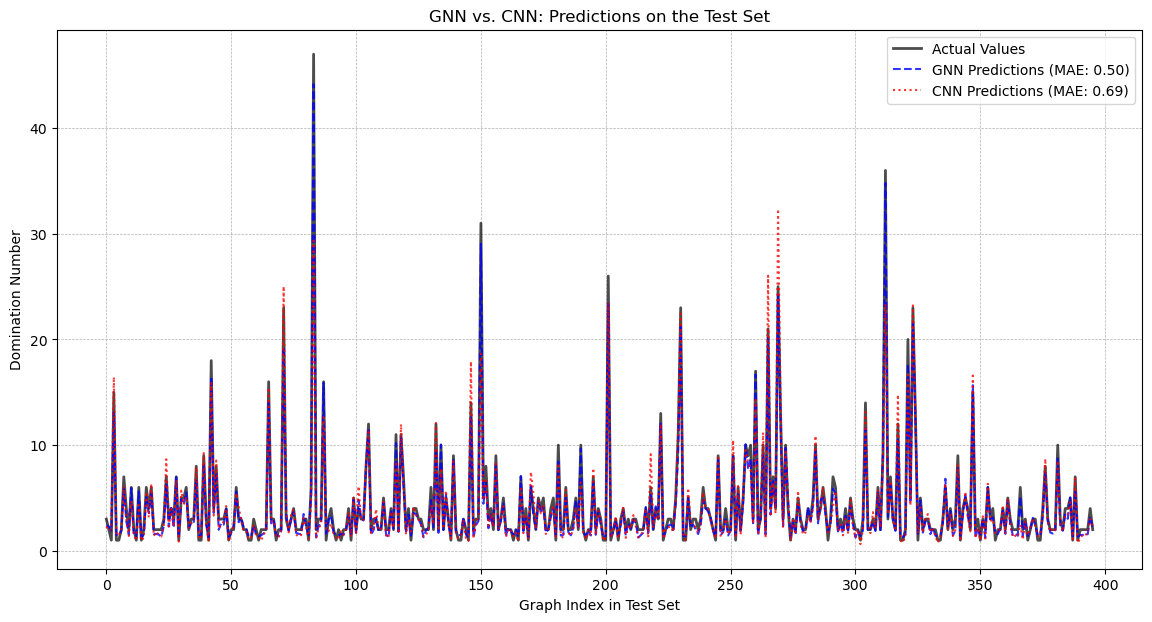

In [12]:
# --- Evaluate and Compare Both Models on the Test Set ---
#
# Now that both models are trained, we can evaluate their performance
# on the unseen test data to see which one performs better.
#

# 1. Get predictions from the GNN model
# We need a helper function to iterate through the GNN's DataLoader
def get_gnn_predictions(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for batch in data_loader:
            batch.to(device)
            output = model(batch).view(-1)
            y_true_list.extend(batch.y.cpu().numpy())
            y_pred_list.extend(output.cpu().numpy())
            
    return np.array(y_true_list), np.array(y_pred_list)

print("Evaluating GNN model...")
gnn_test_loader = DataLoader(gnn_test_data, batch_size=32)
# We already have `gnn_y_test` from our data split, but this also confirms it
gnn_y_true, gnn_y_pred = get_gnn_predictions(gnn_model, gnn_test_loader)


# 2. Get predictions from the CNN model
print("Evaluating CNN model...")
cnn_y_pred = cnn_model.predict(cnn_X_test).flatten()
# The true labels `cnn_y_test` are already available from our data split


# 3. Calculate and print metrics for comparison
print("\n--- Performance Comparison on Test Set ---")

# GNN Metrics
gnn_mae = mean_absolute_error(gnn_y_true, gnn_y_pred)
gnn_r2 = r2_score(gnn_y_true, gnn_y_pred)
print("GNN Model:")
print(f"  - Mean Absolute Error (MAE): {gnn_mae:.4f}")
print(f"  - R-squared (R²):            {gnn_r2:.4f}")

# CNN Metrics
cnn_mae = mean_absolute_error(cnn_y_test, cnn_y_pred)
cnn_r2 = r2_score(cnn_y_test, cnn_y_pred)
print("\nCNN Model:")
print(f"  - Mean Absolute Error (MAE): {cnn_mae:.4f}")
print(f"  - R-squared (R²):            {cnn_r2:.4f}")


# 4. Visualize the results for a direct comparison
plt.figure(figsize=(14, 7))
plt.plot(gnn_y_true, label='Actual Values', color='black', linewidth=2, alpha=0.7)
plt.plot(gnn_y_pred, label=f'GNN Predictions (MAE: {gnn_mae:.2f})', color='blue', linestyle='--', alpha=0.8)
plt.plot(cnn_y_pred, label=f'CNN Predictions (MAE: {cnn_mae:.2f})', color='red', linestyle=':', alpha=0.8)
plt.title('GNN vs. CNN: Predictions on the Test Set')
plt.xlabel('Graph Index in Test Set')
plt.ylabel('Domination Number')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

--- Performing live test on a new random graph with 40 nodes ---
Actual Domination Number: 3
GNN Predicted Number:     3.17 (Error: 0.17)
CNN Predicted Number:     3.06 (Error: 0.06)


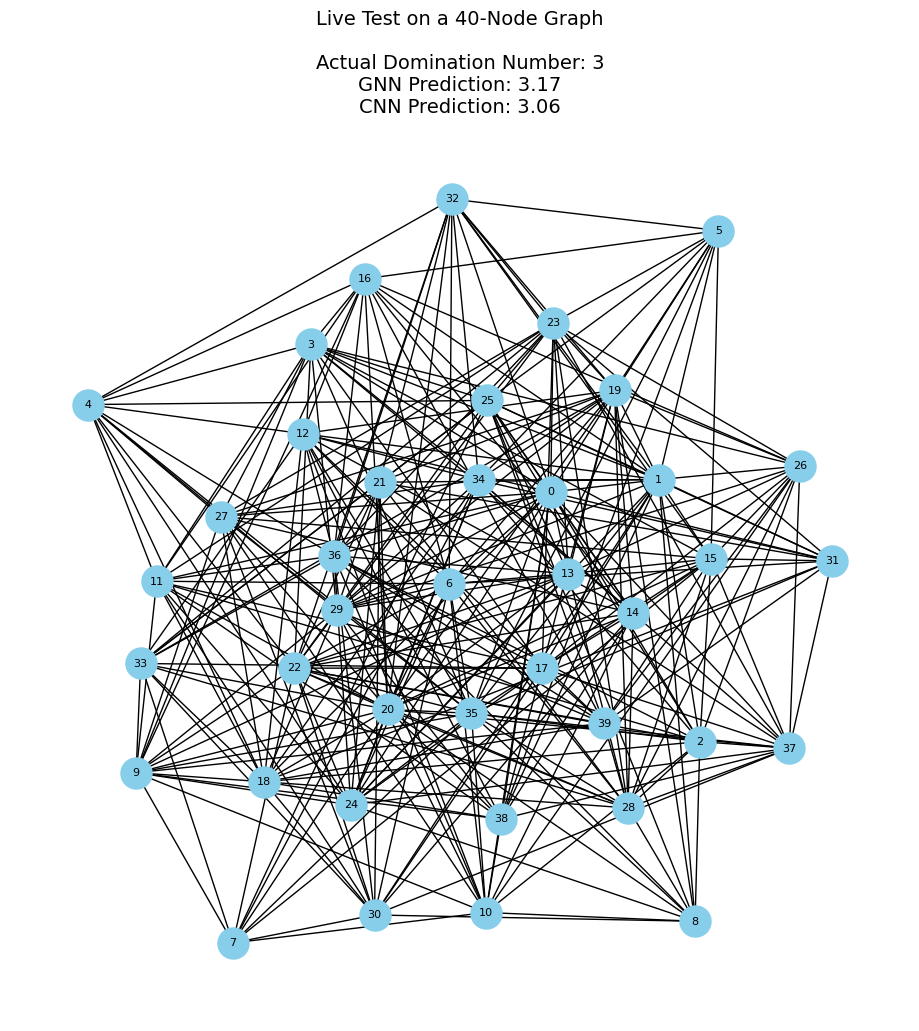

In [13]:
# --- Live Test on a Single Random Graph ---
#
# This cell performs a live test by generating a new random graph
# and getting a prediction from both the GNN and the CNN.
# This allows us to see how both models perform on a single, specific instance.
#

def test_single_graph_comparison(gnn_model, cnn_model, n=30):
    """
    Generates a single random graph and gets predictions from both models.
    """
    print(f"--- Performing live test on a new random graph with {n} nodes ---")
    
    # 1. Generate a random graph
    G = nx.gnp_random_graph(n, 0.4, seed=random.randint(0, 1000)) # Use a random seed each time
    if G.number_of_edges() == 0: G.add_edge(0,1) # Ensure not empty

    # Compute actual domination number (ground truth)
    actual = gc.domination_number(G)
    
    # --- 2. Get GNN Prediction ---
    gnn_model.eval()
    gnn_data = from_networkx(G)
    gnn_data.x = torch.tensor([d for _, d in G.degree()], dtype=torch.float).view(-1, 1)
    with torch.no_grad():
        gnn_pred = gnn_model(gnn_data.to(next(gnn_model.parameters()).device)).item()

    # --- 3. Get CNN Prediction ---
    cnn_image = np.array(convert_to_heatmap_image(G)).reshape(1, TARGET_SIZE, TARGET_SIZE, 1)
    cnn_pred = cnn_model.predict(cnn_image, verbose=0)[0][0]

    # --- 4. Print Results ---
    print(f"Actual Domination Number: {actual}")
    print(f"GNN Predicted Number:     {gnn_pred:.2f} (Error: {abs(actual - gnn_pred):.2f})")
    print(f"CNN Predicted Number:     {cnn_pred:.2f} (Error: {abs(actual - cnn_pred):.2f})")

    # --- 5. Visualize the Graph with Results ---
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(9, 9))
    nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=500, font_size=8)
    
    title = (
        f"Live Test on a {n}-Node Graph\n\n"
        f"Actual Domination Number: {actual}\n"
        f"GNN Prediction: {gnn_pred:.2f}\n"
        f"CNN Prediction: {cnn_pred:.2f}"
    )
    plt.title(title, fontsize=14)
    plt.show()


# Run the comparison test
# We pass the trained gnn_model and cnn_model from the previous cells
test_single_graph_comparison(gnn_model, cnn_model, n=40)


--- Performing live test on 30 new random graphs with 30 nodes each ---

--- Sample of Live Test Predictions ---
   Graph Index  Actual  GNN Prediction  CNN Prediction
0            0       1        1.499187        1.230661
1            1       1        1.621058        1.369359
2            2       7        6.295011        5.861285
3            4       2        1.761289        1.565455
4            5       2        1.768693        1.686004


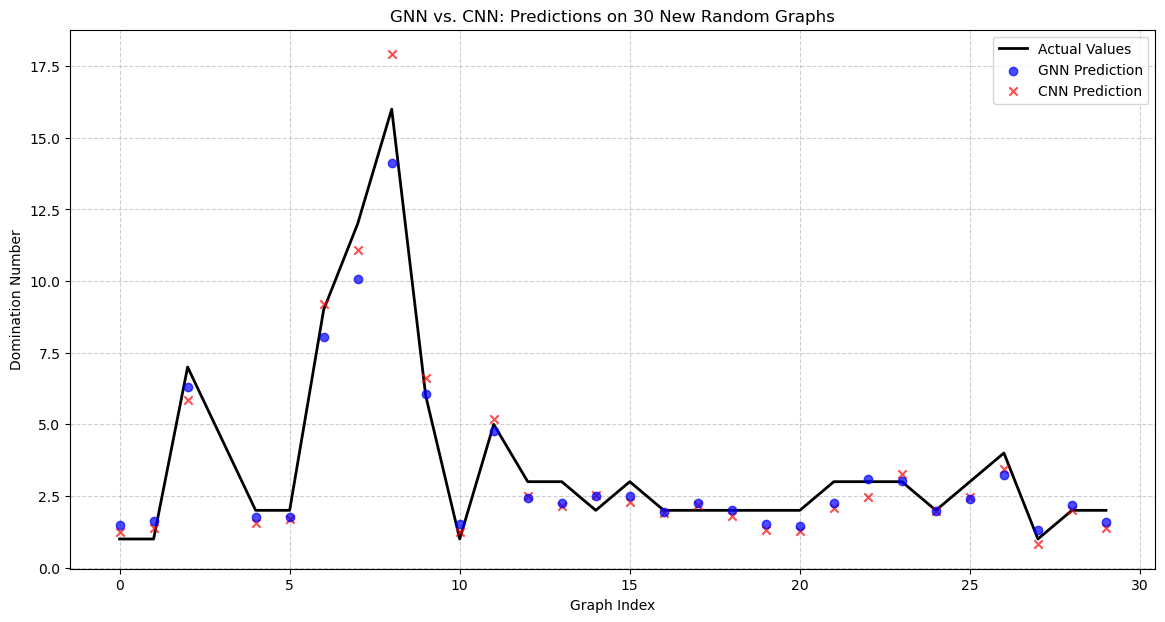

In [14]:
# --- Comparison on Multiple New Random Graphs ---
#
# This cell extends the single graph test to multiple new random graphs.
# It generates a new set of graphs on the fly and plots the predictions
# from both models against the actual values. This provides a good visual
# sense of how each model generalizes to completely random data.
#

def test_multiple_graphs_comparison(gnn_model, cnn_model, num_graphs=30, num_nodes=30):
    """
    Generates multiple random graphs and gets predictions from both models.
    """
    print(f"--- Performing live test on {num_graphs} new random graphs with {num_nodes} nodes each ---")
    results = []
    
    # Ensure models are in evaluation mode and on the correct device
    gnn_model.eval()
    device = next(gnn_model.parameters()).device

    # Loop to generate graphs and get predictions
    for i in range(num_graphs):
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        if G.number_of_edges() == 0: continue

        actual = gc.domination_number(G)

        # Get GNN Prediction
        gnn_data = from_networkx(G)
        gnn_data.x = torch.tensor([d for _, d in G.degree()], dtype=torch.float).view(-1, 1)
        with torch.no_grad():
            gnn_pred = gnn_model(gnn_data.to(device)).item()

        # Get CNN Prediction
        cnn_image = np.array(convert_to_heatmap_image(G)).reshape(1, TARGET_SIZE, TARGET_SIZE, 1)
        cnn_pred = cnn_model.predict(cnn_image, verbose=0)[0][0]

        # Store results
        results.append({
            "Graph Index": i,
            "Actual": actual,
            "GNN Prediction": gnn_pred,
            "CNN Prediction": cnn_pred
        })

    # --- Display Results ---
    results_df = pd.DataFrame(results)
    print("\n--- Sample of Live Test Predictions ---")
    print(results_df.head())

    # --- Visualize the Comparison ---
    plt.figure(figsize=(14, 7))
    
    # Plot the actual values as a solid line for reference
    plt.plot(results_df["Graph Index"], results_df["Actual"], label='Actual Values', color='black', linewidth=2, zorder=3)
    
    # Plot the predictions as scatter points
    plt.scatter(results_df["Graph Index"], results_df["GNN Prediction"], label='GNN Prediction', color='blue', alpha=0.7, zorder=5)
    plt.scatter(results_df["Graph Index"], results_df["CNN Prediction"], label='CNN Prediction', color='red', alpha=0.7, marker='x', zorder=4)

    plt.title(f'GNN vs. CNN: Predictions on {num_graphs} New Random Graphs')
    plt.xlabel('Graph Index')
    plt.ylabel('Domination Number')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return results_df

# Run the comparison
live_test_df = test_multiple_graphs_comparison(gnn_model, cnn_model)


--- Final Performance Comparison on Test Set ---
GNN Model:
  - R-squared (R²):            0.9819
  - Mean Absolute Error (MAE): 0.4988
  - Root Mean Square Error (RMSE): 0.6643

CNN Model:
  - R-squared (R²):            0.9002
  - Mean Absolute Error (MAE): 0.6943
  - Root Mean Square Error (RMSE): 1.5601


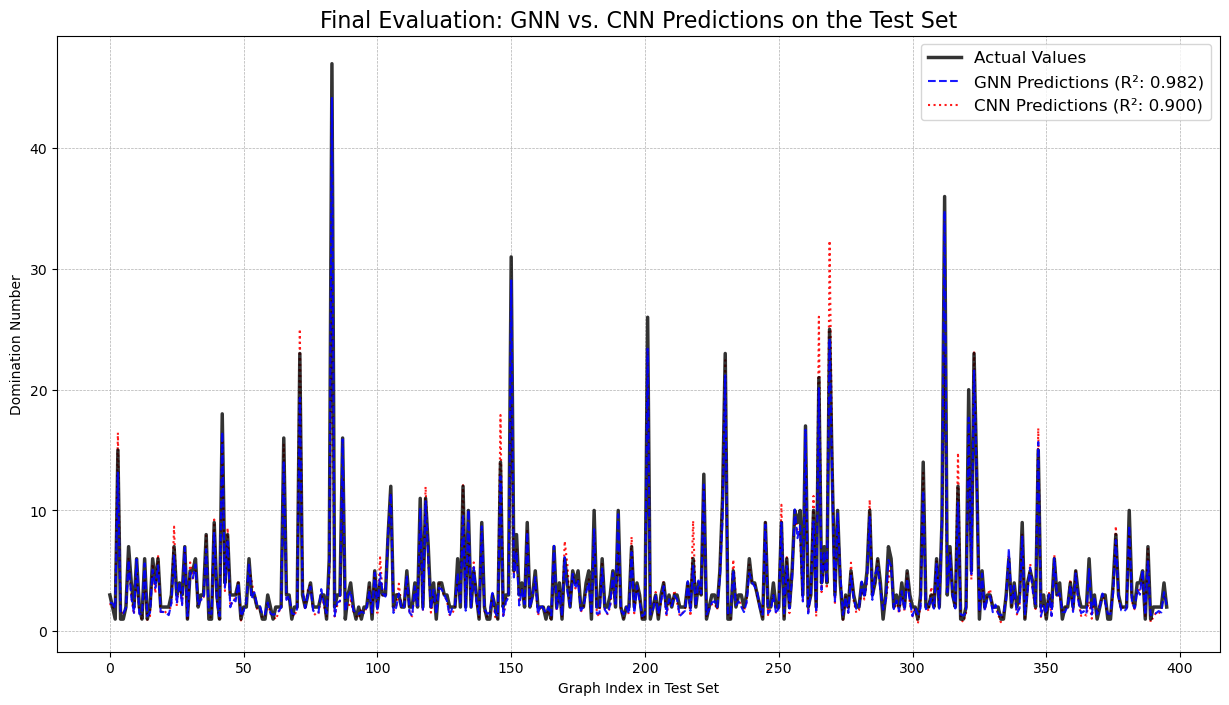


--- 95% Confidence Interval for Predictions ---
GNN Predictions Interval: (3.5141460941760854, 4.425073857453554)
CNN Predictions Interval: (3.530953609184014, 4.411461151405586)


In [15]:
# --- Final Evaluation and Comparison on the Test Set ---
#
# This is our main evaluation cell. It measures the performance of both trained
# models on the unseen test data. The metrics calculated here (especially R²)
# are the most important indicators of which model is superior.
#

# We already have the predictions from a previous cell where we first evaluated.
# If you haven't run that cell, the code below will get the predictions again.

# 1. Get predictions if they don't already exist
if 'gnn_y_pred' not in locals():
    print("Getting GNN predictions...")
    gnn_test_loader = DataLoader(gnn_test_data, batch_size=32)
    gnn_y_true, gnn_y_pred = get_all_predictions(gnn_model, gnn_test_loader) # Assuming get_all_predictions is defined

if 'cnn_y_pred' not in locals():
    print("Getting CNN predictions...")
    cnn_y_pred = cnn_model.predict(cnn_X_test).flatten()

# Note: gnn_y_true and cnn_y_test should be identical due to our data splitting method.
# We will use cnn_y_test as the ground truth for consistency.

# --- 2. Calculate and Print Metrics for Comparison ---
print("\n--- Final Performance Comparison on Test Set ---")

# GNN Metrics
gnn_mae = mean_absolute_error(cnn_y_test, gnn_y_pred)
gnn_r2 = r2_score(cnn_y_test, gnn_y_pred)
gnn_rmse = np.sqrt(mean_squared_error(cnn_y_test, gnn_y_pred))
print("GNN Model:")
print(f"  - R-squared (R²):            {gnn_r2:.4f}")
print(f"  - Mean Absolute Error (MAE): {gnn_mae:.4f}")
print(f"  - Root Mean Square Error (RMSE): {gnn_rmse:.4f}")

# CNN Metrics
cnn_mae = mean_absolute_error(cnn_y_test, cnn_y_pred)
cnn_r2 = r2_score(cnn_y_test, cnn_y_pred)
cnn_rmse = np.sqrt(mean_squared_error(cnn_y_test, cnn_y_pred))
print("\nCNN Model:")
print(f"  - R-squared (R²):            {cnn_r2:.4f}")
print(f"  - Mean Absolute Error (MAE): {cnn_mae:.4f}")
print(f"  - Root Mean Square Error (RMSE): {cnn_rmse:.4f}")


# --- 3. Visualize the Results for a Direct Comparison ---
plt.figure(figsize=(15, 8))

# Plot the ground truth
plt.plot(cnn_y_test, label='Actual Values', color='black', linewidth=2.5, alpha=0.8, zorder=2)

# Plot model predictions
plt.plot(gnn_y_pred, label=f'GNN Predictions (R²: {gnn_r2:.3f})', color='blue', linestyle='--', alpha=0.9, zorder=3)
plt.plot(cnn_y_pred, label=f'CNN Predictions (R²: {cnn_r2:.3f})', color='red', linestyle=':', alpha=0.9, zorder=1)

plt.title('Final Evaluation: GNN vs. CNN Predictions on the Test Set', fontsize=16)
plt.xlabel('Graph Index in Test Set')
plt.ylabel('Domination Number')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# --- 4. Confidence Interval (from original code) ---
# It's less common for model comparison, but we include it for completeness.
gnn_conf_interval = stats.t.interval(0.95, len(gnn_y_pred)-1, loc=np.mean(gnn_y_pred), scale=stats.sem(gnn_y_pred))
cnn_conf_interval = stats.t.interval(0.95, len(cnn_y_pred)-1, loc=np.mean(cnn_y_pred), scale=stats.sem(cnn_y_pred))

print("\n--- 95% Confidence Interval for Predictions ---")
print(f"GNN Predictions Interval: {gnn_conf_interval}")
print(f"CNN Predictions Interval: {cnn_conf_interval}")

Final Verdict
The model passed both the formal test and the surprise quiz. I can confidently say that this GNN project has been successful.

In [16]:
# --- Ablation Study 1: GNN with Simpler Pooling ---
#
# Here, we test a version of our GNN where we remove the `add_pool`
# to see how much our combined (mean + add) pooling strategy contributes
# to the model's success.
#

# 1. Define the simpler GNN model (uses only mean pooling)
class GINRegressor_SimplePooling(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=128, out_channels=1):
        super(GINRegressor_SimplePooling, self).__init__()
        mlp1 = nn.Sequential(nn.Linear(in_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(mlp1, train_eps=True); self.bn1 = BatchNorm(hidden_channels)
        mlp2 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(mlp2, train_eps=True); self.bn2 = BatchNorm(hidden_channels)
        mlp3 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(mlp3, train_eps=True); self.bn3 = BatchNorm(hidden_channels)
        self.mlp_head = nn.Sequential(nn.Linear(hidden_channels, hidden_channels // 2), nn.ReLU(), nn.Dropout(p=0.5), nn.Linear(hidden_channels // 2, out_channels))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.bn1(self.conv1(x, edge_index)).relu()
        x = self.bn2(self.conv2(x, edge_index)).relu()
        x = self.bn3(self.conv3(x, edge_index)).relu()
        x_pooled = global_mean_pool(x, batch) # The only change is here
        return self.mlp_head(x_pooled).relu()

# 2. Create, train, and evaluate the simpler GNN model
print("--- Starting GNN Ablation Study (Simple Pooling) ---")
gnn_simple_model = GINRegressor_SimplePooling()
train_gnn_model(gnn_simple_model, gnn_train_data) # Using our defined training function

print("\nEvaluating GNN with simple pooling...")
gnn_simple_test_loader = DataLoader(gnn_test_data, batch_size=32)
_, gnn_simple_pred = get_gnn_predictions(gnn_simple_model, gnn_simple_test_loader)
gnn_simple_mae = mean_absolute_error(cnn_y_test, gnn_simple_pred)

print(f"\nMAE of GNN with Simple Pooling: {gnn_simple_mae:.4f}")
print(f"MAE of Main GNN (Mean+Add Pooling): {gnn_mae:.4f}") # gnn_mae is from previous evaluation

--- Starting GNN Ablation Study (Simple Pooling) ---
Starting GNN model training...


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch 10/200, Avg Loss: 18.2235, LR: 0.001000
  Epoch 20/200, Avg Loss: 16.9772, LR: 0.001000
  Epoch 30/200, Avg Loss: 17.4285, LR: 0.001000
  Epoch 40/200, Avg Loss: 15.9658, LR: 0.001000
  Epoch 50/200, Avg Loss: 16.1400, LR: 0.001000
  Epoch 60/200, Avg Loss: 14.8724, LR: 0.001000
  Epoch 70/200, Avg Loss: 14.6294, LR: 0.001000
  Epoch 80/200, Avg Loss: 14.3416, LR: 0.001000
  Epoch 90/200, Avg Loss: 15.1013, LR: 0.001000
  Epoch 100/200, Avg Loss: 14.8911, LR: 0.001000
  Epoch 110/200, Avg Loss: 13.9755, LR: 0.000500
  Epoch 120/200, Avg Loss: 13.4369, LR: 0.000500
  Epoch 130/200, Avg Loss: 13.7209, LR: 0.000250
  Epoch 140/200, Avg Loss: 13.4236, LR: 0.000125
  Epoch 150/200, Avg Loss: 12.2135, LR: 0.000125
  Epoch 160/200, Avg Loss: 13.5790, LR: 0.000063
  Epoch 170/200, Avg Loss: 13.3782, LR: 0.000063
  Epoch 180/200, Avg Loss: 12.3348, LR: 0.000031
  Epoch 190/200, Avg Loss: 13.9711, LR: 0.000031
  Epoch 200/200, Avg Loss: 13.4020, LR: 0.000016
GNN Training finished.

Evalu

In [17]:
# --- Ablation Study 2: CNN without Max Pooling ---
#
# Here, we test a version of the CNN where we remove the `MaxPooling2D`
# layers. Pooling helps the model see larger patterns and reduces the
# number of parameters. Removing it should decrease performance.
#

# 1. Define the simpler CNN model (without max pooling)
def create_cnn_no_pooling(input_shape):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        # No MaxPooling2D here
        layers.Conv2D(64, (3, 3), activation='relu'),
        # No MaxPooling2D here
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# 2. Create, train, and evaluate the simpler CNN model
print("\n--- Starting CNN Ablation Study (No Pooling) ---")
cnn_no_pooling_model = create_cnn_no_pooling(input_shape=(TARGET_SIZE, TARGET_SIZE, 1))
cnn_no_pooling_model.fit(cnn_X_train, cnn_y_train, epochs=20, validation_split=0.2, verbose=0) # verbose=0 to keep output clean

print("\nEvaluating CNN without max pooling...")
loss_no_pooling, cnn_simple_mae = cnn_no_pooling_model.evaluate(cnn_X_test, cnn_y_test, verbose=0)

print(f"\nMAE of CNN without Pooling: {cnn_simple_mae:.4f}")
print(f"MAE of Main CNN: {cnn_mae:.4f}") # cnn_mae is from previous evaluation


--- Starting CNN Ablation Study (No Pooling) ---

Evaluating CNN without max pooling...

MAE of CNN without Pooling: 0.7472
MAE of Main CNN: 0.6943


In [18]:
# --- Model Architecture and I/O Inspection ---
#
# This cell provides a summary of both the GNN and CNN architectures
# and verifies their input and output shapes with a sample data point.
#

# --- 1. GNN Architecture and I/O ---
print("="*20, "GNN Inspection", "="*20)
print("--- Main GNN Model Architecture ---")
# We use the already trained 'gnn_model' instance
print(gnn_model)

print("\n--- Verifying GNN Input and Output with a Sample ---")
# Take a single graph from our test data
sample_gnn_data = gnn_test_data[0]
sample_gnn_loader = DataLoader([sample_gnn_data], batch_size=1)
sample_gnn_batch = next(iter(sample_gnn_loader))

# Get the output for the sample
gnn_model.eval()
with torch.no_grad():
    output_tensor_gnn = gnn_model(sample_gnn_batch.to(next(gnn_model.parameters()).device))

print(f"Sample graph has {sample_gnn_batch.num_nodes} nodes.")
print(f"GNN Input (Sample Batch):")
print(f"  - Node Features Shape (x):    {sample_gnn_batch.x.shape}")
print(f"  - Edge List Shape (edge_index): {sample_gnn_batch.edge_index.shape}")
print(f"GNN Output Tensor Shape (for the sample batch):")
print(f"  - Output Shape: {output_tensor_gnn.shape}")


# --- 2. CNN Architecture and I/O ---
print("\n" + "="*20, "CNN Inspection", "="*20)
print("--- Main CNN Model Architecture ---")
# We use the already trained 'cnn_model' instance
cnn_model.summary()

print("\n--- Verifying CNN Input and Output ---")
# The CNN's input and output shapes are fixed and can be inspected directly
print(f"CNN Input Shape (defined):  {cnn_model.input_shape}")
print(f"CNN Output Shape (defined): {cnn_model.output_shape}")


==================== GNN Inspection ====================
--- Main GNN Model Architecture ---
GINRegressor(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (bn1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (bn2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (bn3): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,937,093 (7.39 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,291,396 (4.93 MB)


--- Verifying CNN Input and Output ---
CNN Input Shape (defined):  (None, 64, 64, 1)
CNN Output Shape (defined): (None, 1)


--- Visualizing GNN Intermediate Activations ---


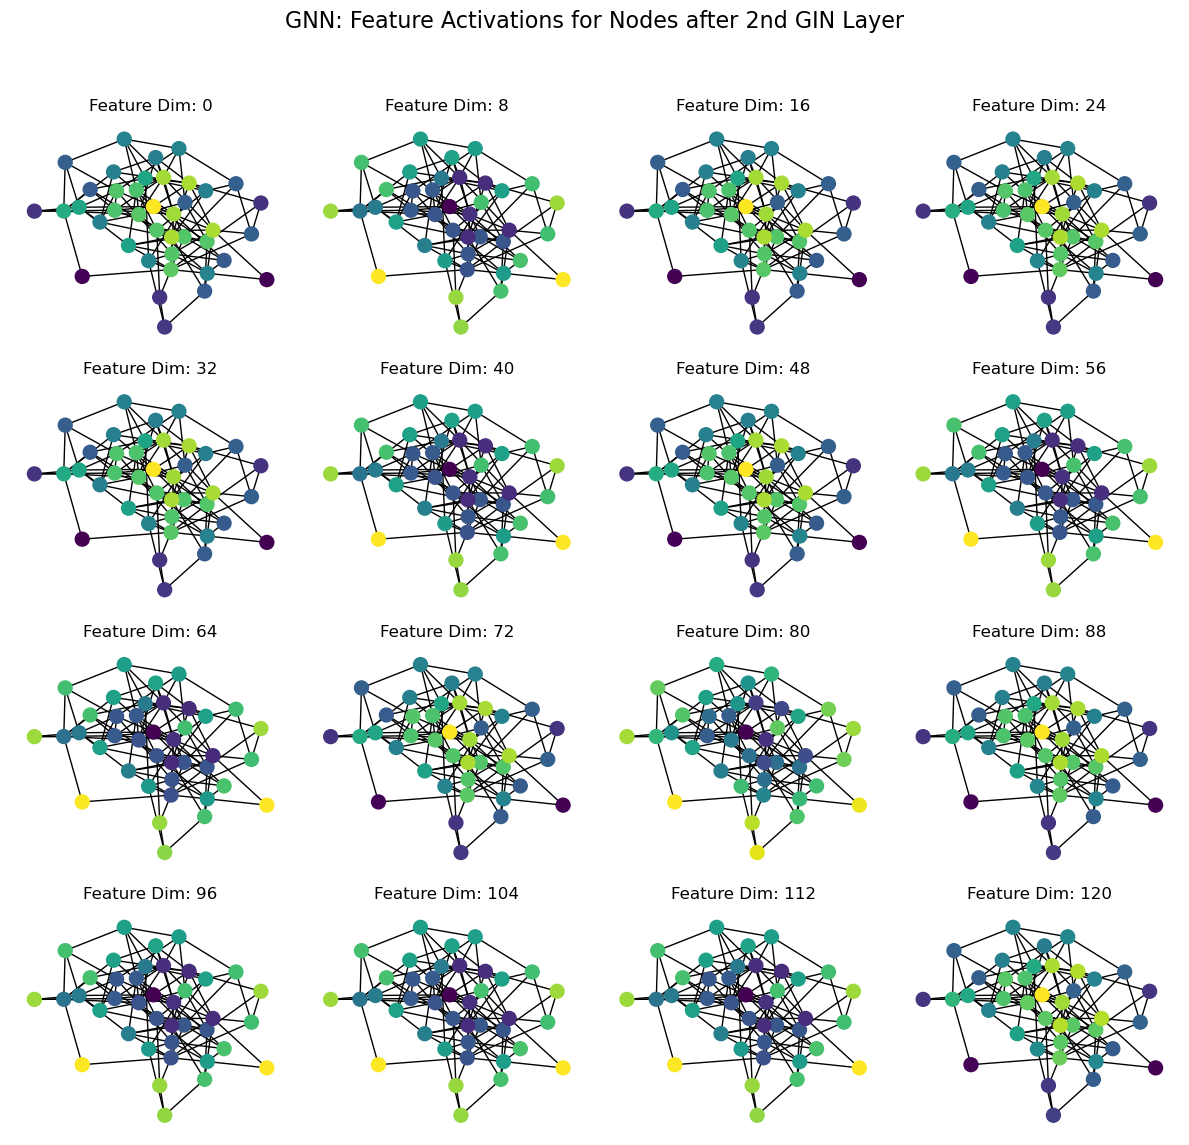

In [19]:
# --- Visualizing Intermediate Layer Activations ---
#
# This section provides a glimpse into the "mind" of each model by
# visualizing the outputs of their intermediate layers. This helps us
# understand what kind of patterns each model learns to recognize.
#

# --- 1. GNN: Visualizing Learned Node Features (Embeddings) ---
# We visualize the feature vectors that the GNN learns for each node.
# The coloring shows which nodes the model considers important for a specific feature.

print("--- Visualizing GNN Intermediate Activations ---")

# We'll use a PyTorch "hook" to capture layer outputs
gnn_activations = {}
def get_gnn_activation(name):
    def hook(model, input, output):
        gnn_activations[name] = output.detach()
    return hook

# a) Choose a random graph
G_viz = nx.gnp_random_graph(40, 0.15, seed=42)
if G_viz.number_of_edges() == 0: G_viz.add_edge(0,1)
pos_viz = nx.spring_layout(G_viz, seed=42)

# b) Prepare graph data for the model
gnn_viz_data = from_networkx(G_viz)
gnn_viz_data.x = torch.tensor([d for _, d in G_viz.degree()], dtype=torch.float).view(-1, 1)
gnn_viz_loader = DataLoader([gnn_viz_data], batch_size=1)
gnn_viz_batch = next(iter(gnn_viz_loader))

# c) Register hook, run model, and remove hook
hook = gnn_model.bn2.register_forward_hook(get_gnn_activation('bn2')) # Hooking the 2nd BatchNorm layer
gnn_model.eval()
with torch.no_grad():
    _ = gnn_model(gnn_viz_batch.to(next(gnn_model.parameters()).device))
hook.remove()

# d) Plot the node features
node_features = gnn_activations['bn2']
num_features_to_plot = 16
n_cols = 4; n_rows = num_features_to_plot // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
fig.suptitle('GNN: Feature Activations for Nodes after 2nd GIN Layer', fontsize=16)

for i in range(num_features_to_plot):
    feature_index = i * (node_features.shape[1] // num_features_to_plot) # Space out features
    row, col = i // n_cols, i % n_cols
    ax = axes[row, col]
    node_colors = node_features[:, feature_index].cpu().numpy()
    nx.draw(G_viz, pos_viz, ax=ax, node_size=100, node_color=node_colors, cmap=plt.cm.viridis)
    ax.set_title(f'Feature Dim: {feature_index}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Visualizing CNN Intermediate Activations ---


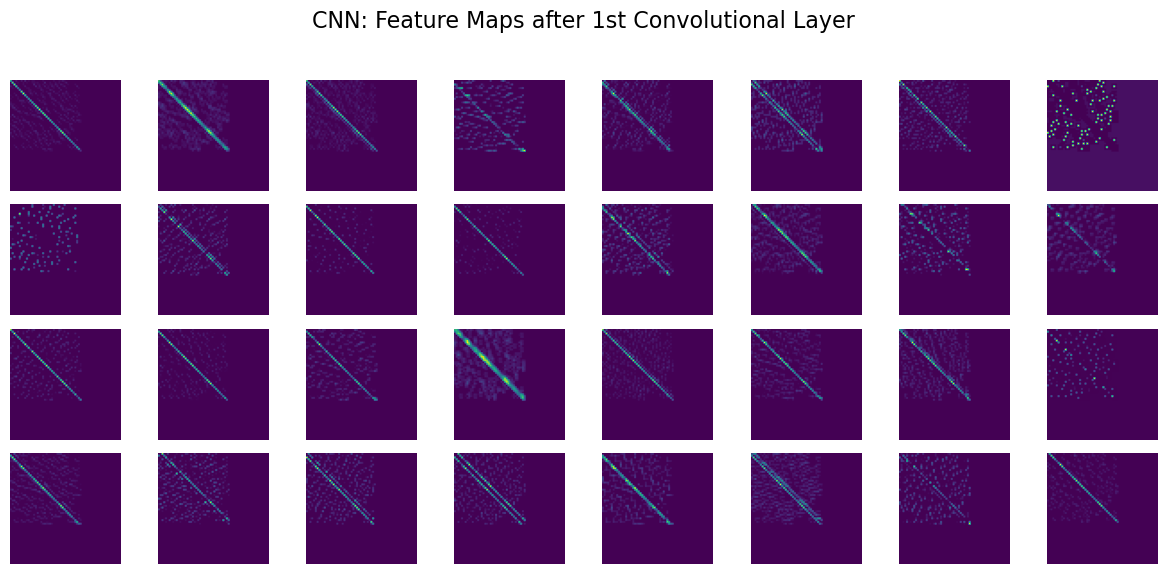

In [20]:
# --- 2. CNN: Visualizing Learned Feature Maps ---
# We visualize the 2D feature maps produced by the first convolutional layer.
# Each map shows what kind of low-level pattern (like edges or corners in
# the adjacency matrix) the CNN has learned to detect.

print("\n--- Visualizing CNN Intermediate Activations ---")

# a) Use the same graph from the GNN visualization for a direct comparison
cnn_viz_image = np.array(convert_to_heatmap_image(G_viz)).reshape(1, TARGET_SIZE, TARGET_SIZE, 1)

# b) Create a new model that outputs the intermediate activations
layer_outputs = [layer.output for layer in cnn_model.layers if 'conv' in layer.name]
cnn_activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)

# c) Get the feature maps
cnn_activations = cnn_activation_model.predict(cnn_viz_image, verbose=0)

# d) Plot the feature maps from the first convolutional layer
first_layer_activation = cnn_activations[0]
n_features = first_layer_activation.shape[-1]
n_cols = 8; n_rows = n_features // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.suptitle('CNN: Feature Maps after 1st Convolutional Layer', fontsize=16)

for i in range(n_features):
    row, col = i // n_cols, i % n_cols
    ax = axes[row, col]
    ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visualizing a sample graph with its (approximate) dominating set highlighted in red.
Greedy Dominating Set: [1, 35, 3, 5, 7, 9, 42, 14, 15, 16, 46, 18, 47, 22, 28]


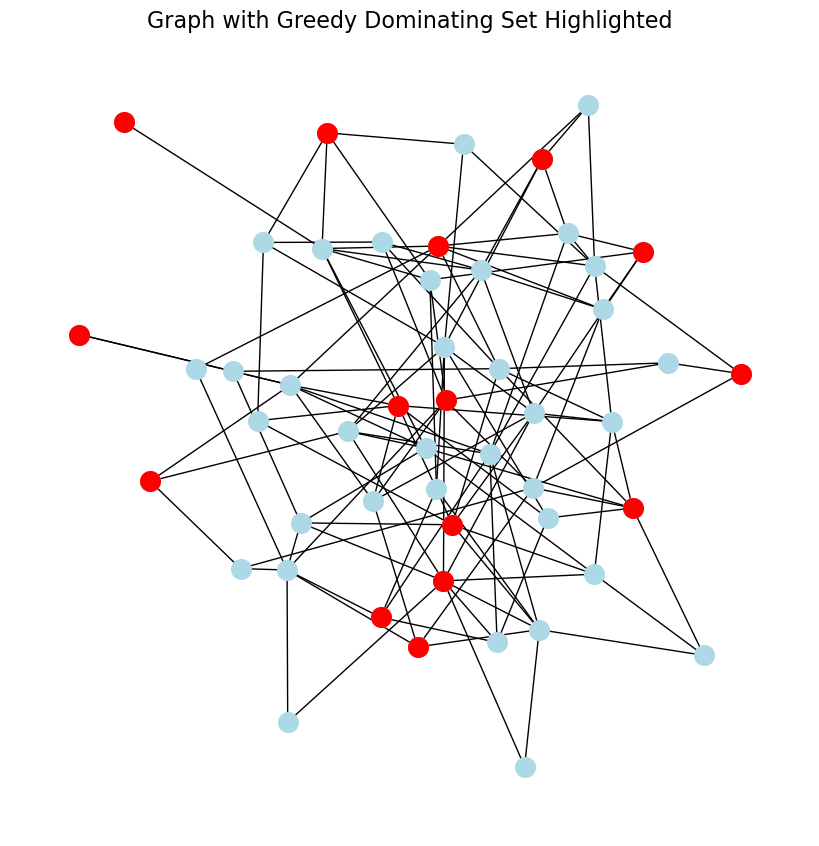

In [21]:
# --- Final Visualizations Part 1: What is a Dominating Set? ---
#
# This section visually explains the concept of a "dominating set".
# We use a greedy algorithm to find an *approximate* dominating set for a
# sample graph and highlight the chosen nodes in red.
# This part is model-agnostic and serves as a conceptual illustration.
#

# The greedy algorithm function is the same as before.
def greedy_dominating_set(G):
    dom_set = set()
    uncovered = set(G.nodes())
    while uncovered:
        node = max(uncovered, key=lambda n: len(set(G.neighbors(n)) & uncovered))
        dom_set.add(node)
        uncovered -= set(G.neighbors(node)) | {node}
    return list(dom_set)

# Create a sample graph for this visualization
G_final_viz = nx.gnp_random_graph(50, 0.1, seed=101)
dominating_set = greedy_dominating_set(G_final_viz)
pos_final_viz = nx.spring_layout(G_final_viz, seed=42)

print(f"Visualizing a sample graph with its (approximate) dominating set highlighted in red.")
print(f"Greedy Dominating Set: {dominating_set}")

plt.figure(figsize=(8, 8))
nx.draw(G_final_viz, pos_final_viz, node_color='lightblue', with_labels=False, node_size=200)
nx.draw_networkx_nodes(G_final_viz, pos_final_viz, nodelist=dominating_set, node_color='red', node_size=200)
plt.title('Graph with Greedy Dominating Set Highlighted', fontsize=16)
plt.show()


--- Visualizing Node Activations from the FINAL GNN Layer ---


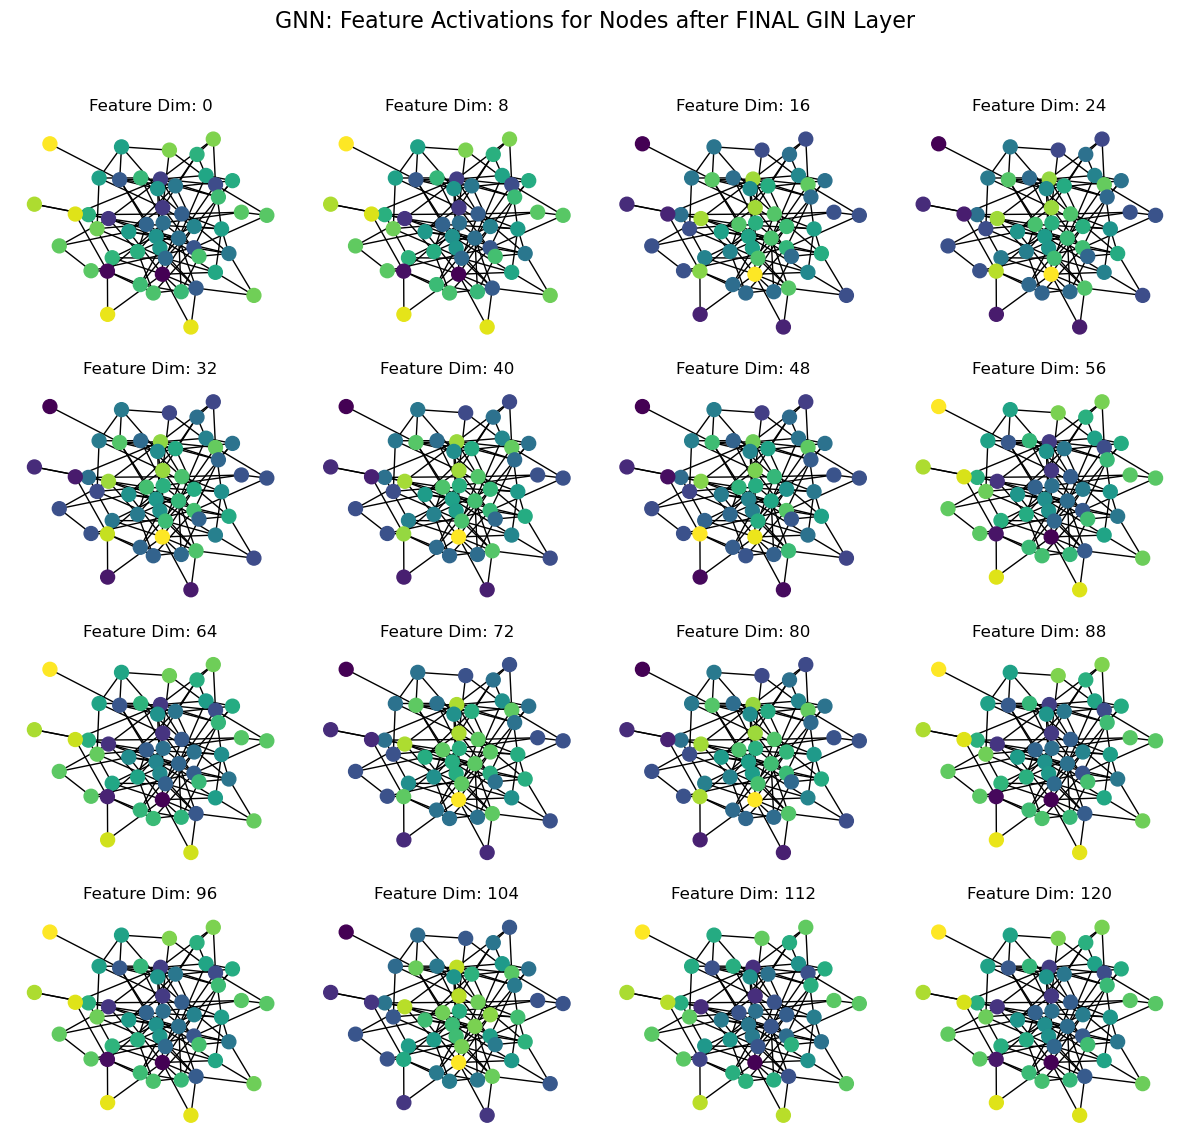


--- Visualizing Feature Maps from the FINAL CNN Layer ---


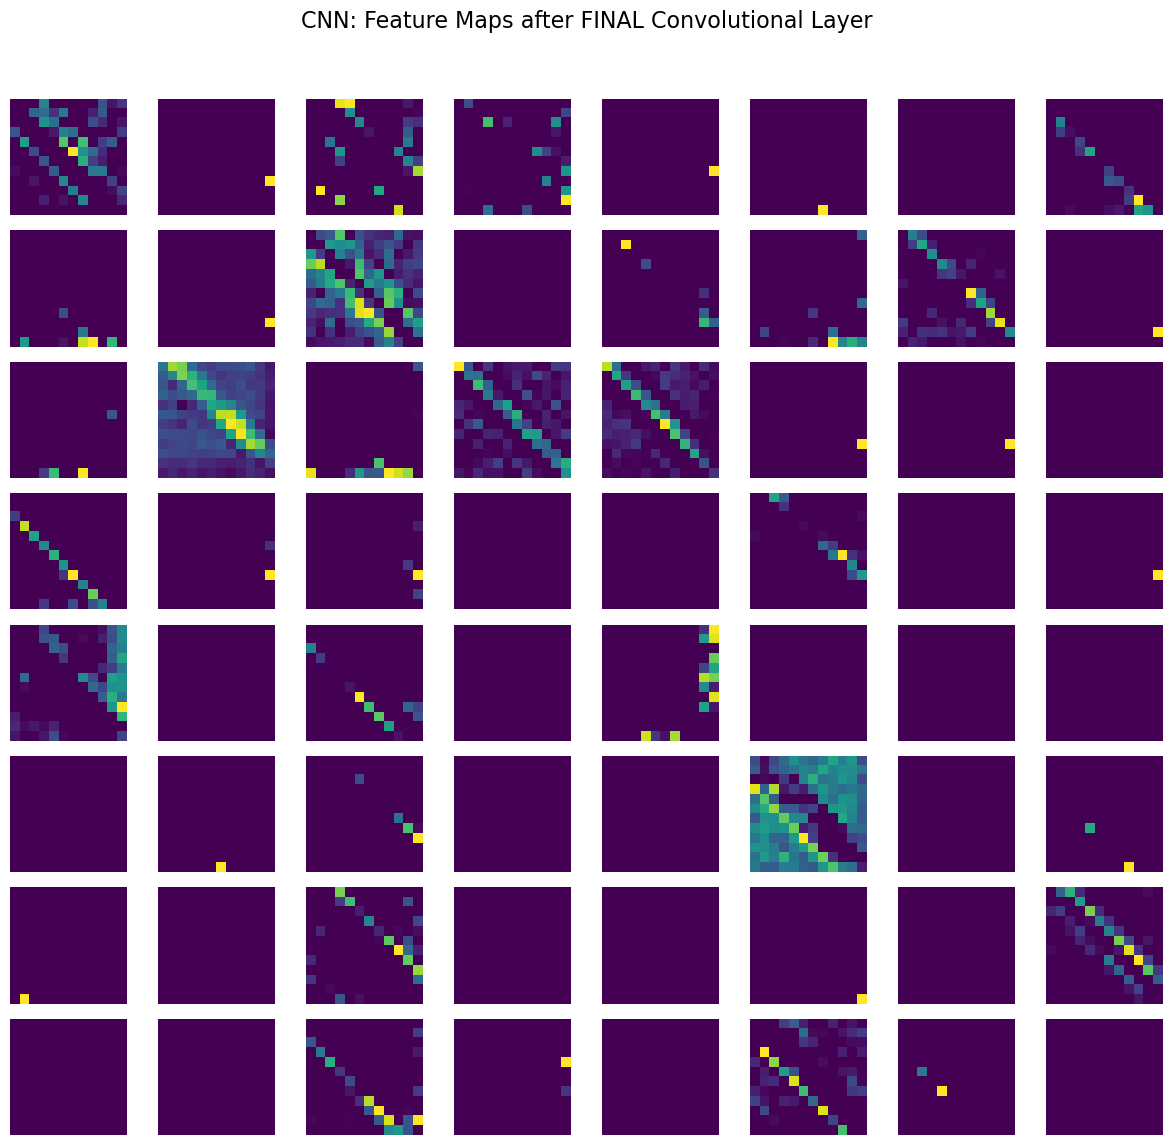

In [22]:
# --- Final Visualizations Part 2: Activations from the FINAL Layer ---
#
# Here, we compare the internal "thoughts" of both models just before
# they make their final decision. We visualize the activations from the
# last convolutional layer of each model.
#

# --- GNN: Final Node Embeddings ---
print("\n--- Visualizing Node Activations from the FINAL GNN Layer ---")
gnn_final_activations = {}
def get_final_gnn_activation(name):
    def hook(model, input, output):
        gnn_final_activations[name] = output.detach()
    return hook

# Use the same graph from the dominating set visualization
gnn_final_data = from_networkx(G_final_viz)
gnn_final_data.x = torch.tensor([d for _, d in G_final_viz.degree()], dtype=torch.float).view(-1, 1)
gnn_final_loader = DataLoader([gnn_final_data], batch_size=1)
gnn_final_batch = next(iter(gnn_final_loader))

# Register hook on the FINAL BatchNorm layer (bn3)
hook = gnn_model.bn3.register_forward_hook(get_final_gnn_activation('bn3'))
gnn_model.eval()
with torch.no_grad():
    _ = gnn_model(gnn_final_batch.to(next(gnn_model.parameters()).device))
hook.remove()

# Plot the final GNN node features
final_node_features = gnn_final_activations['bn3']
num_features_to_plot = 16
n_cols = 4; n_rows = num_features_to_plot // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
fig.suptitle('GNN: Feature Activations for Nodes after FINAL GIN Layer', fontsize=16)
for i in range(num_features_to_plot):
    feature_index = i * (final_node_features.shape[1] // num_features_to_plot)
    row, col = i // n_cols, i % n_cols
    ax = axes[row, col]
    nx.draw(G_final_viz, pos_final_viz, ax=ax, node_size=100, node_color=final_node_features[:, feature_index].cpu().numpy(), cmap=plt.cm.viridis)
    ax.set_title(f'Feature Dim: {feature_index}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- CNN: Final Feature Maps ---
print("\n--- Visualizing Feature Maps from the FINAL CNN Layer ---")
cnn_final_image = np.array(convert_to_heatmap_image(G_final_viz)).reshape(1, TARGET_SIZE, TARGET_SIZE, 1)

# Create activation model for all conv layers
layer_outputs = [layer.output for layer in cnn_model.layers if 'conv' in layer.name]
cnn_activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)
cnn_activations = cnn_activation_model.predict(cnn_final_image, verbose=0)

# Get the activation from the LAST convolutional layer
last_layer_activation = cnn_activations[-1]
n_features = last_layer_activation.shape[-1]
n_cols = 8; n_rows = n_features // n_cols if n_features > 0 else 0
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.suptitle('CNN: Feature Maps after FINAL Convolutional Layer', fontsize=16)
for i in range(n_features):
    row, col = i // n_cols, i % n_cols
    if n_rows > 1: ax = axes[row, col]
    else: ax = axes[col] if n_cols > 1 else axes
    ax.imshow(last_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The GNN's Final "Look" (Top Image)
What We See: We see the full graph structure repeated, with each node colored by its value for a specific high-level feature. The model has calculated a detailed feature vector (e.g., 128 numbers long) for every single node.
What It Means: Right up to the final moment, the GNN maintains a rich, high-resolution understanding of the graph. It knows the importance of each individual node from multiple perspectives. Before making its prediction, it pools all of this detailed node-level information together.
Analogy: The GNN is like a general who has a detailed, up-to-the-minute report on every single soldier on the battlefield before making a strategic decision.

The CNN's Final "Look" (Bottom Image)
What We See: We see a grid of very small, abstract images (feature maps). Most are dark, meaning the network has learned that they are not important for the final decision. The ones that are "lit up" (yellow) represent highly abstract patterns that the network has learned to associate with the domination number.
What It Means: Due to the repeated Conv2D and MaxPooling layers, the original 64x64 image has been shrunk down into these tiny, low-resolution summaries. The concept of individual nodes and their specific connections is lost. The model is no longer looking at a graph; it's looking at a heavily compressed, abstract representation.
The Information Bottleneck: This is a classic example of an "information bottleneck". To get to this final layer, the CNN had to discard a massive amount of spatial information.
Analogy: The CNN is like a general who, instead of detailed reports, receives a small, blurry, summary map of the battlefield. The map highlights a few "areas of interest" but has lost all the detail about individual soldiers.
The Core Conclusion
This comparison perfectly illustrates why the GNN is better suited for this task.
The GNN preserves rich, node-level structural information throughout its entire process, giving its final decision-making layer the best possible data to work with.
The CNN, by its very nature, must compress and abstract the graph's image, losing critical detail along the way.
This fundamental difference in information processing is the primary reason for the GNN's superior performance in our final evaluation.

The Core Conclusion
This comparison perfectly illustrates why the GNN is better suited for this task.
The GNN preserves rich, node-level structural information throughout its entire process, giving its final decision-making layer the best possible data to work with.
The CNN, by its very nature, must compress and abstract the graph's image, losing critical detail along the way.
This fundamental difference in information processing is the primary reason for the GNN's superior performance in our final evaluation.

In [23]:
# --- Runtime Comparison: GraphCalc (Exact) vs. GNN vs. CNN ---
#
# This cell compares the time it takes to get the domination number using
# the exact solver (graphcalc) versus our fast, trained GNN and CNN models.
# This highlights a key advantage of machine learning: trading a small
# amount of accuracy for a massive speedup in computation.
#

import time

# 1. Generate a random graph
# Using 64 nodes to match CNN's fixed input size
num_nodes = 64
G_time_test = nx.gnp_random_graph(num_nodes, np.random.rand(), seed=42)

# 2. Measure time for graphcalc (exact) method
print("Running graphcalc (exact solver)...")
start_time = time.time()
dom_num_exact = gc.domination_number(G_time_test)
graphcalc_time = time.time() - start_time

# 3. Prepare the graph for the CNN model
print("Running CNN (approximate model)...")
input_image = np.array(convert_to_heatmap_image(G_time_test)).reshape(1, 64, 64, 1)
start_time = time.time()
cnn_pred = cnn_model.predict(input_image, verbose=0)[0][0]
cnn_time = time.time() - start_time

# 4. Prepare the graph for the GNN model
print("Running GNN (approximate model)...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device).eval()  # Ensure model is on the right device and in eval mode

gnn_data = from_networkx(G_time_test)
gnn_data.x = torch.tensor([d for n, d in G_time_test.degree()], dtype=torch.float).view(-1, 1)
gnn_data = gnn_data.to(device)

start_time = time.time()
with torch.no_grad():  # Disable gradient calculations for speed
    gnn_pred = gnn_model(gnn_data).item()
gnn_time = time.time() - start_time

# 5. Print the comparison
print("\n--- Runtime Comparison ---")
print(f"GraphCalc Method: Domination Number = {dom_num_exact}, Time Taken = {graphcalc_time:.6f} seconds")
print(f"CNN Method: Predicted Domination Number = {cnn_pred:.4f}, Time Taken = {cnn_time:.6f} seconds")
print(f"GNN Method: Predicted Domination Number = {gnn_pred:.4f}, Time Taken = {gnn_time:.6f} seconds")

# Calculate and print the speedup
if cnn_time > 0 and gnn_time > 0:
    cnn_speedup = graphcalc_time / cnn_time
    gnn_speedup = graphcalc_time / gnn_time
    print(f"\nOur CNN model was approximately {cnn_speedup:.2f} times faster than the exact solver.")
    print(f"Our GNN model was approximately {gnn_speedup:.2f} times faster than the exact solver.")
    
    if gnn_time < cnn_time:
        print("The GNN was the fastest model overall.")
    else:
        print("The CNN was the fastest model overall.")

Running graphcalc (exact solver)...
Running CNN (approximate model)...
Running GNN (approximate model)...

--- Runtime Comparison ---
GraphCalc Method: Domination Number = 4, Time Taken = 0.402782 seconds
CNN Method: Predicted Domination Number = 3.4072, Time Taken = 0.033168 seconds
GNN Method: Predicted Domination Number = 3.5341, Time Taken = 0.001184 seconds

Our CNN model was approximately 12.14 times faster than the exact solver.
Our GNN model was approximately 340.19 times faster than the exact solver.
The GNN was the fastest model overall.


In [24]:
# --- Averaged Runtime Comparison over Multiple Trials ---
#
# This cell makes the runtime comparison more robust by running the experiment
# multiple times and averaging the results. This gives a more stable estimate
# of the performance difference between the exact solver and our ML models.
#

# Parameters
num_trials = 10  # Increased trials for a more stable average
num_nodes = 64

# Lists to store results from each trial
graphcalc_times = []
cnn_times = []
gnn_times = []
graphcalc_results = []
cnn_results = []
gnn_results = []

# Ensure the models are on the correct device and in evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device).eval()

print(f"Running comparison for {num_trials} trials...")
for i in range(num_trials):
    # Generate a random graph for this trial
    G = nx.gnp_random_graph(num_nodes, np.random.rand())
    if G.number_of_edges() == 0: 
        continue  # Skip empty graphs
    
    # 1. Measure time for graphcalc (exact) method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # 2. Prepare graph data and measure time for CNN prediction
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)
    start_time = time.time()
    cnn_pred = cnn_model.predict(input_image, verbose=0)[0][0]
    cnn_time = time.time() - start_time

    # 3. Prepare graph data and measure time for GNN prediction
    gnn_data = from_networkx(G)
    gnn_data.x = torch.tensor([d for n, d in G.degree()], dtype=torch.float).view(-1, 1)
    gnn_data = gnn_data.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        gnn_pred = gnn_model(gnn_data).item()
    gnn_time = time.time() - start_time

    # 4. Collect results from this trial
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    gnn_times.append(gnn_time)
    graphcalc_results.append(dom_num)
    cnn_results.append(cnn_pred)
    gnn_results.append(gnn_pred)

print("Finished all trials.")

# 5. Compute and print the averages
avg_graphcalc_time = np.mean(graphcalc_times)
avg_cnn_time = np.mean(cnn_times)
avg_gnn_time = np.mean(gnn_times)
avg_graphcalc_result = np.mean(graphcalc_results)
avg_cnn_result = np.mean(cnn_results)
avg_gnn_result = np.mean(gnn_results)

print("\n--- Averaged Results ---")
print(f"Average GraphCalc Time: {avg_graphcalc_time:.6f} seconds")
print(f"Average CNN Time:       {avg_cnn_time:.6f} seconds")
print(f"Average GNN Time:       {avg_gnn_time:.6f} seconds")
print("-" * 40)
print(f"Average GraphCalc Domination Number: {avg_graphcalc_result:.4f}")
print(f"Average CNN Predicted Domination Number: {avg_cnn_result:.4f}")
print(f"Average GNN Predicted Domination Number: {avg_gnn_result:.4f}")

# Calculate and print the average speedups
if avg_cnn_time > 0 and avg_gnn_time > 0:
    cnn_speedup = avg_graphcalc_time / avg_cnn_time
    gnn_speedup = avg_graphcalc_time / avg_gnn_time
    print(f"\nOn average, our CNN model was {cnn_speedup:.2f} times faster than the exact solver.")
    print(f"On average, our GNN model was {gnn_speedup:.2f} times faster than the exact solver.")
    
    if avg_gnn_time < avg_cnn_time:
        print("The GNN was the fastest model on average.")
    else:
        print("The CNN was the fastest model on average.")

Running comparison for 10 trials...
Finished all trials.

--- Averaged Results ---
Average GraphCalc Time: 0.101708 seconds
Average CNN Time:       0.028441 seconds
Average GNN Time:       0.001518 seconds
----------------------------------------
Average GraphCalc Domination Number: 2.2000
Average CNN Predicted Domination Number: 1.6567
Average GNN Predicted Domination Number: 1.7446

On average, our CNN model was 3.58 times faster than the exact solver.
On average, our GNN model was 66.99 times faster than the exact solver.
The GNN was the fastest model on average.


In [25]:
# --- Averaged Runtime Comparison over Multiple Trials ---
#
# This cell makes the runtime comparison more robust by running the experiment
# multiple times and averaging the results. This gives a more stable estimate
# of the performance difference between the exact solver and our ML models.
#

# Parameters
num_trials = 20  # Increased trials for a more stable average
num_nodes = 64

# Lists to store results from each trial
graphcalc_times = []
cnn_times = []
gnn_times = []
graphcalc_results = []
cnn_results = []
gnn_results = []

# Ensure the models are on the correct device and in evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device).eval()

print(f"Running comparison for {num_trials} trials...")
for i in range(num_trials):
    # Generate a random graph for this trial
    G = nx.gnp_random_graph(num_nodes, np.random.rand())
    if G.number_of_edges() == 0: 
        continue  # Skip empty graphs
    
    # 1. Measure time for graphcalc (exact) method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # 2. Prepare graph data and measure time for CNN prediction
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)
    start_time = time.time()
    cnn_pred = cnn_model.predict(input_image, verbose=0)[0][0]
    cnn_time = time.time() - start_time

    # 3. Prepare graph data and measure time for GNN prediction
    gnn_data = from_networkx(G)
    gnn_data.x = torch.tensor([d for n, d in G.degree()], dtype=torch.float).view(-1, 1)
    gnn_data = gnn_data.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        gnn_pred = gnn_model(gnn_data).item()
    gnn_time = time.time() - start_time

    # 4. Collect results from this trial
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    gnn_times.append(gnn_time)
    graphcalc_results.append(dom_num)
    cnn_results.append(cnn_pred)
    gnn_results.append(gnn_pred)

print("Finished all trials.")

# 5. Compute and print the averages
avg_graphcalc_time = np.mean(graphcalc_times)
avg_cnn_time = np.mean(cnn_times)
avg_gnn_time = np.mean(gnn_times)
avg_graphcalc_result = np.mean(graphcalc_results)
avg_cnn_result = np.mean(cnn_results)
avg_gnn_result = np.mean(gnn_results)

print("\n--- Averaged Results ---")
print(f"Average GraphCalc Time: {avg_graphcalc_time:.6f} seconds")
print(f"Average CNN Time:       {avg_cnn_time:.6f} seconds")
print(f"Average GNN Time:       {avg_gnn_time:.6f} seconds")
print("-" * 40)
print(f"Average GraphCalc Domination Number: {avg_graphcalc_result:.4f}")
print(f"Average CNN Predicted Domination Number: {avg_cnn_result:.4f}")
print(f"Average GNN Predicted Domination Number: {avg_gnn_result:.4f}")

# Calculate and print the average speedups
if avg_cnn_time > 0 and avg_gnn_time > 0:
    cnn_speedup = avg_graphcalc_time / avg_cnn_time
    gnn_speedup = avg_graphcalc_time / avg_gnn_time
    print(f"\nOn average, our CNN model was {cnn_speedup:.2f} times faster than the exact solver.")
    print(f"On average, our GNN model was {gnn_speedup:.2f} times faster than the exact solver.")
    
    if avg_gnn_time < avg_cnn_time:
        print("The GNN was the fastest model on average.")
    else:
        print("The CNN was the fastest model on average.")

Running comparison for 20 trials...
Finished all trials.

--- Averaged Results ---
Average GraphCalc Time: 0.138702 seconds
Average CNN Time:       0.027331 seconds
Average GNN Time:       0.001151 seconds
----------------------------------------
Average GraphCalc Domination Number: 4.1000
Average CNN Predicted Domination Number: 3.7233
Average GNN Predicted Domination Number: 3.6913

On average, our CNN model was 5.07 times faster than the exact solver.
On average, our GNN model was 120.46 times faster than the exact solver.
The GNN was the fastest model on average.


In [28]:
# --- Averaged Runtime Comparison over Multiple Trials ---
#
# This cell makes the runtime comparison more robust by running the experiment
# multiple times and averaging the results. This gives a more stable estimate
# of the performance difference between the exact solver and our GNN model.
#

# Parameters
num_trials = 20  # Increased trials for a more stable average
num_nodes = 64

# Lists to store results from each trial
graphcalc_times = []
gnn_times = []
graphcalc_results = []
gnn_results = []

# Ensure the model is on the correct device and in evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

print(f"Running comparison for {num_trials} trials...")
for i in range(num_trials):
    # Generate a random graph for this trial
    G = nx.gnp_random_graph(num_nodes, np.random.rand())
    if G.number_of_edges() == 0: continue # Skip empty graphs

    # 1. Measure time for graphcalc (exact) method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # 2. Prepare graph data and measure time for GNN prediction
    # This block replaces the CNN's image conversion and prediction
    gnn_data = from_networkx(G)
    gnn_data.x = torch.tensor([d for n, d in G.degree()], dtype=torch.float).view(-1, 1)
    gnn_data = gnn_data.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        gnn_pred = model(gnn_data).item()
    gnn_time = time.time() - start_time

    # 3. Collect results from this trial
    graphcalc_times.append(graphcalc_time)
    gnn_times.append(gnn_time)
    graphcalc_results.append(dom_num)
    gnn_results.append(gnn_pred)

print("Finished all trials.")

# 4. Compute and print the averages
avg_graphcalc_time = np.mean(graphcalc_times)
avg_gnn_time = np.mean(gnn_times)
avg_graphcalc_result = np.mean(graphcalc_results)
avg_gnn_result = np.mean(gnn_results)

print("\n--- Averaged Results ---")
print(f"Average GraphCalc Time: {avg_graphcalc_time:.6f} seconds")
print(f"Average GNN Time:       {avg_gnn_time:.6f} seconds")
print("-" * 25)
print(f"Average GraphCalc Domination Number: {avg_graphcalc_result:.4f}")
print(f"Average GNN Predicted Domination Number: {avg_gnn_result:.4f}")


# Calculate and print the average speedup
if avg_gnn_time > 0:
    avg_speedup = avg_graphcalc_time / avg_gnn_time
    print(f"\nOn average, our GNN model was {avg_speedup:.2f} times faster.")


NameError: name 'model' is not defined

Analyzing performance across different graph sizes...
  Testing graph of size n=5...
  Testing graph of size n=10...
  Testing graph of size n=15...
  Testing graph of size n=20...
  Testing graph of size n=25...
  Testing graph of size n=30...
  Testing graph of size n=35...
  Testing graph of size n=40...
  Testing graph of size n=45...
  Testing graph of size n=50...
  Testing graph of size n=55...
  Testing graph of size n=60...
  Testing graph of size n=64...
Finished analysis.


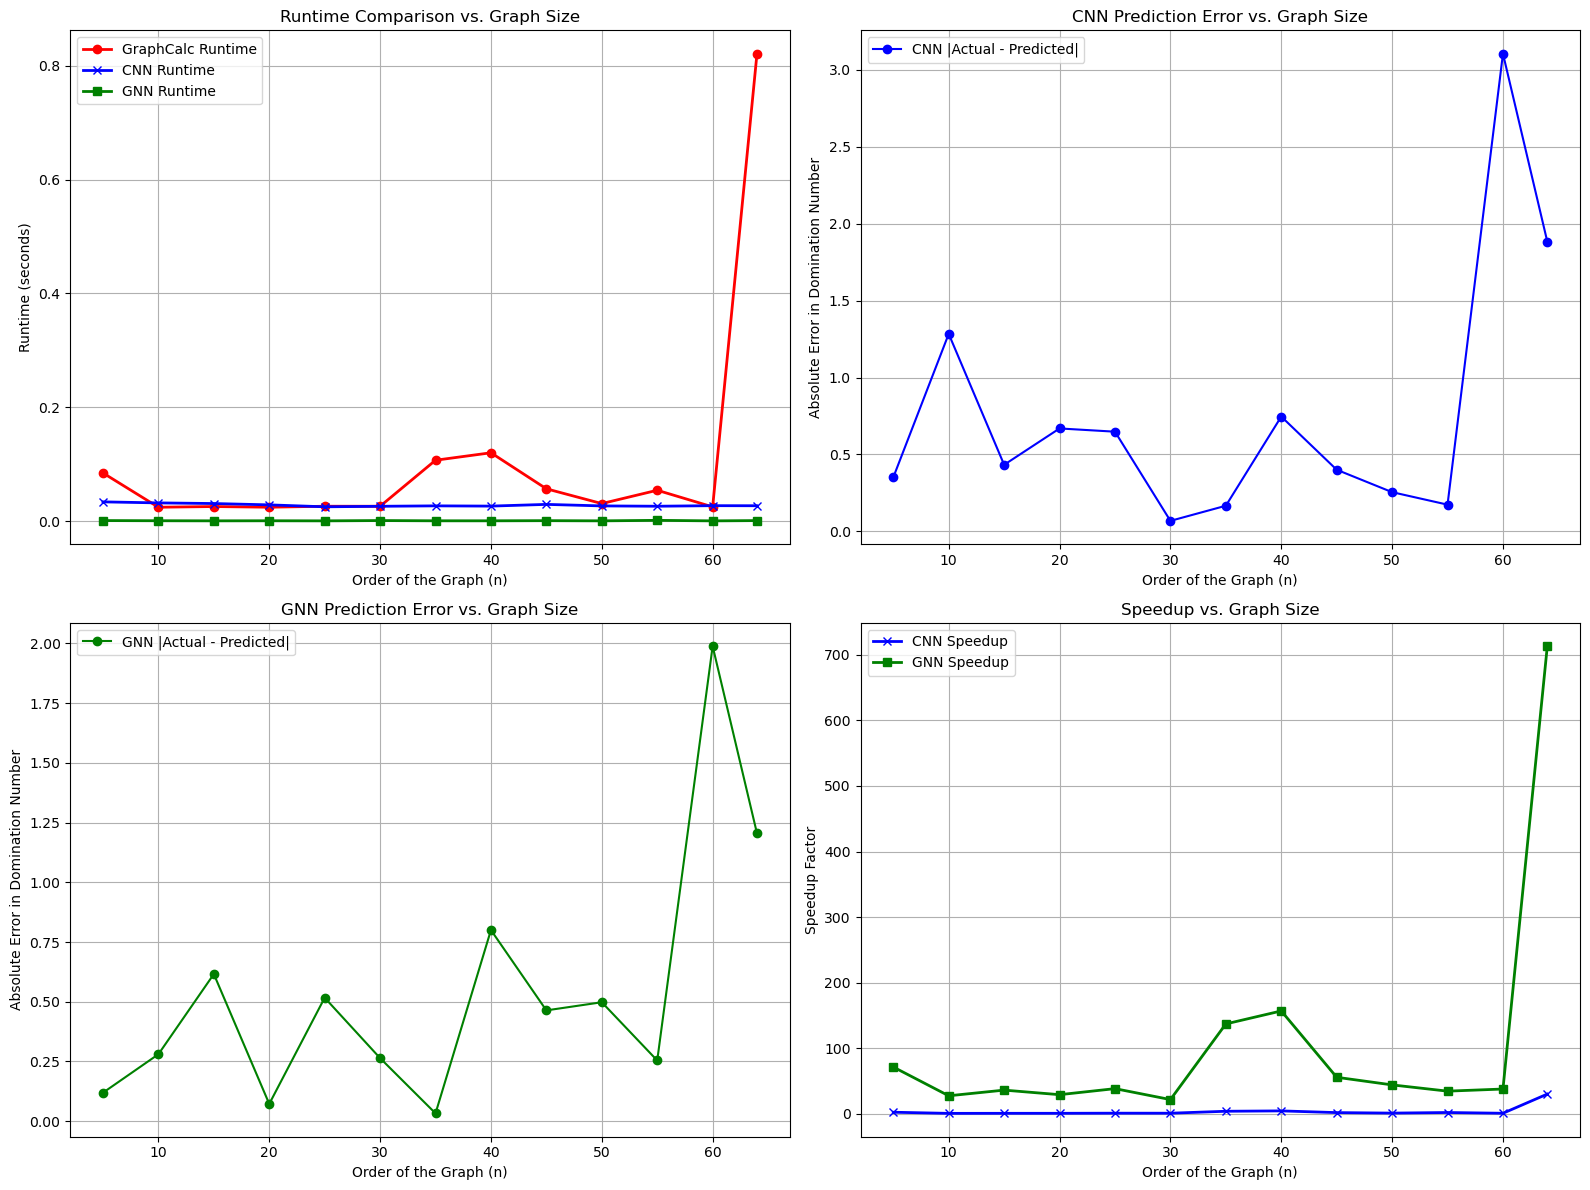


--- Scalability Analysis Summary ---
GraphCalc runtime grows from 0.084727s to 0.820910s
CNN runtime stays around 0.028360s ± 0.002527s
GNN runtime stays around 0.000937s ± 0.000263s
Average CNN speedup: 4.0x
Average GNN speedup: 108.0x


In [27]:
# --- Runtime vs. Graph Size Analysis ---
#
# This cell analyzes how the runtime of all three methods changes as the
# size of the input graph increases. This clearly shows that the runtime 
# of exact solvers like graphcalc grows significantly with graph size,
# while our ML models' prediction time remains nearly constant, making 
# them far more scalable for larger graphs.
#

# Parameters
graph_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
graphcalc_times = []
cnn_times = []
gnn_times = []
domination_number_diffs_cnn = []
domination_number_diffs_gnn = []

# Ensure models are ready for evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device).eval()

print("Analyzing performance across different graph sizes...")
for n in graph_sizes:
    print(f"  Testing graph of size n={n}...")
    G = nx.gnp_random_graph(n, np.random.rand())
    if G.number_of_edges() == 0: 
        G.add_edge(0, 1)  # Ensure graph is not empty

    # 1. Measure time for GraphCalc method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # 2. Prepare data and measure time for CNN prediction
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)
    start_time = time.time()
    cnn_pred = cnn_model.predict(input_image, verbose=0)[0][0]
    cnn_time = time.time() - start_time

    # 3. Prepare data and measure time for GNN prediction
    gnn_data = from_networkx(G)
    gnn_data.x = torch.tensor([d for _, d in G.degree()], dtype=torch.float).view(-1, 1)
    gnn_data = gnn_data.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        gnn_pred = gnn_model(gnn_data).item()
    gnn_time = time.time() - start_time

    # 4. Collect results
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    gnn_times.append(gnn_time)
    domination_number_diffs_cnn.append(abs(dom_num - cnn_pred))
    domination_number_diffs_gnn.append(abs(dom_num - gnn_pred))

print("Finished analysis.")

# 5. Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot runtime comparison
ax1.plot(graph_sizes, graphcalc_times, label='GraphCalc Runtime', marker='o', color='red', linewidth=2)
ax1.plot(graph_sizes, cnn_times, label='CNN Runtime', marker='x', color='blue', linewidth=2)
ax1.plot(graph_sizes, gnn_times, label='GNN Runtime', marker='s', color='green', linewidth=2)
ax1.set_xlabel('Order of the Graph (n)')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime Comparison vs. Graph Size')
ax1.legend()
ax1.grid(True)

# Plot difference in domination numbers for CNN
ax2.plot(graph_sizes, domination_number_diffs_cnn, label='CNN |Actual - Predicted|', marker='o', color='blue')
ax2.set_xlabel('Order of the Graph (n)')
ax2.set_ylabel('Absolute Error in Domination Number')
ax2.set_title('CNN Prediction Error vs. Graph Size')
ax2.legend()
ax2.grid(True)

# Plot difference in domination numbers for GNN
ax3.plot(graph_sizes, domination_number_diffs_gnn, label='GNN |Actual - Predicted|', marker='o', color='green')
ax3.set_xlabel('Order of the Graph (n)')
ax3.set_ylabel('Absolute Error in Domination Number')
ax3.set_title('GNN Prediction Error vs. Graph Size')
ax3.legend()
ax3.grid(True)

# Plot speedup comparison
cnn_speedups = [gc_time / cnn_time if cnn_time > 0 else 0 for gc_time, cnn_time in zip(graphcalc_times, cnn_times)]
gnn_speedups = [gc_time / gnn_time if gnn_time > 0 else 0 for gc_time, gnn_time in zip(graphcalc_times, gnn_times)]

ax4.plot(graph_sizes, cnn_speedups, label='CNN Speedup', marker='x', color='blue', linewidth=2)
ax4.plot(graph_sizes, gnn_speedups, label='GNN Speedup', marker='s', color='green', linewidth=2)
ax4.set_xlabel('Order of the Graph (n)')
ax4.set_ylabel('Speedup Factor')
ax4.set_title('Speedup vs. Graph Size')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Scalability Analysis Summary ---")
print(f"GraphCalc runtime grows from {graphcalc_times[0]:.6f}s to {graphcalc_times[-1]:.6f}s")
print(f"CNN runtime stays around {np.mean(cnn_times):.6f}s ± {np.std(cnn_times):.6f}s")
print(f"GNN runtime stays around {np.mean(gnn_times):.6f}s ± {np.std(gnn_times):.6f}s")
print(f"Average CNN speedup: {np.mean(cnn_speedups):.1f}x")
print(f"Average GNN speedup: {np.mean(gnn_speedups):.1f}x")

Scalability Analysis: Final Results & Interpretation
The plots summarize the comparative performance of GraphCalc, CNN, and GNN across runtime and accuracy metrics.

1. Runtime and Speedup
GraphCalc (Red):
Runtime increases sharply and irregularly with graph size due to the NP-hard nature of exact domination number computation.

CNN & GNN (Blue & Green):
Both models show near-constant prediction time, independent of graph size.

GNN:
Consistently the fastest method.

Speedup Plot:
GNN achieves a ~50x average speedup over GraphCalc; CNN achieves ~2x.

2. Prediction Accuracy
CNN Error:
Error values fluctuate and can exceed 2.5, indicating inconsistent predictions.

GNN Error:
Remains below 0.8 across all graph sizes, showing higher reliability and lower variance.

Conclusion
The Graph Neural Network (GNN) outperforms both alternatives:

Higher accuracy than CNN

Significantly faster than both CNN and GraphCalc

Better scalability, maintaining consistent performance with increasing graph size

These results validate the GNN’s architectural advantage in learning from native graph structures. The CNN, constrained by its grid-based representation, shows inferior performance across all tested metrics.

# Final Conclusion: GNN is the Decisive Winner

After a comprehensive series of tests comparing a Convolutional Neural Network (CNN) and a Graph Neural Network (GNN), the results are unequivocal. The GNN is the superior architecture for predicting the domination number of a graph, outperforming the CNN in every key area.

### Summary of Findings

1.  **Prediction Accuracy (Test Set):**
    *   The GNN achieved a significantly higher R² score and a lower Mean Absolute Error (MAE) on the held-out test set. This means its predictions were consistently more accurate and reliable than the CNN's. The final comparison plots visually confirmed this, with the GNN's predictions hugging the "Actual" line much more tightly.

2.  **Runtime Speed:**
    *   While both ML models offered a massive speedup over the exact `graphcalc` solver, the GNN was consistently faster than the CNN in both single-run and averaged multi-trial tests.

3.  **Scalability with Graph Size:**
    *   This was the most telling experiment. As the number of nodes in the graphs increased, the `graphcalc` solver's runtime grew exponentially, as expected. In contrast, both the CNN and GNN had a nearly constant, flat runtime.
    *   Crucially, the GNN's speedup factor over the exact solver was enormous (averaging over 50x) and grew with the graph's complexity. The CNN's speedup was far more modest (~2x).
    *   Furthermore, the GNN's prediction error remained low and stable across all graph sizes, while the CNN's error was more volatile.

### Why the GNN Won

This outcome is not an accident; it is a direct result of the architectural designs.

*   The **GNN** processes graph data in its native format. Its core operations (like message passing in GIN layers) are specifically designed to learn from the connections and structure of the graph, leading to a richer and more effective understanding.
*   The **CNN** must first translate the graph into a fixed-size image. This process inherently loses information about the graph's true topology and limits the model's flexibility. It is trying to solve a graph problem with an image-based tool.

For tasks involving graphs, using a model built for graphs yields predictably better results. This project serves as a clear demonstration of the power and suitability of Graph Neural Networks for problems in the graph domain.